In [2]:
import sys
sys.path.append(r'C:\Users\gustavo\Documents\Data Science\08-GitHub\Portifolio/Classification/titanic_version_1')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import yaml
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# open yaml
yaml_path = r"C:\Users\gustavo\Documents\Data Science\08-GitHub\Portifolio\Classification\titanic_version_1\src\config.yaml"
with open(yaml_path, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

    params = {        
        'X_train_feat_sel':os.path.join(
            config['feat_selection']['path'],
            config['feat_selection']['X_train']),
        'X_val_feat_sel':os.path.join(
            config['feat_selection']['path'],
            config['feat_selection']['X_val']),
        'y_train_feat_sel': os.path.join(
            config['feat_selection']['path'],
            config['feat_selection']['y_train']),
        'y_val_feat_sel':os.path.join(
            config['feat_selection']['path'],
            config['feat_selection']['y_val']),
        'save_plot':config['save_reports']['path_plot'],
        'save_report':config['save_reports']['path_reports'],
        'model_version': config['model']['model_version']
        }

In [3]:
config['model_version']

KeyError: 'model_version'

In [7]:
X_train = pd.read_parquet(params['X_train_feat_sel'])
X_val = pd.read_parquet(params['X_val_feat_sel'])
y_train = pd.read_parquet(params['y_train_feat_sel'])
y_val = pd.read_parquet(params['y_val_feat_sel'])
    
    
sfs = SFS(
        estimator=RandomForestClassifier(random_state=23),
        k_features=X_train.shape[1]-1,  
        forward=True,  
        floating=False,  
        scoring='accuracy',
        cv=5, 
        n_jobs=-1
        )    
    
sfs_pipe = make_pipeline(sfs)    


In [8]:
sfs_fit = sfs_pipe.fit(X_train, y_train)

In [11]:
results = pd.DataFrame.from_dict(sfs_pipe.named_steps['sequentialfeatureselector'].subsets_).T


In [22]:
results[['feature_names', 'avg_score']].to_dict(orient='index')

{1: {'feature_names': ('categorical_pipe__Sex_male',),
  'avg_score': 0.7829648748737515},
 2: {'feature_names': ('numerical_pipe__FamilySize',
   'categorical_pipe__Sex_male'),
  'avg_score': 0.7994613399169566},
 3: {'feature_names': ('numerical_pipe__FamilySize',
   'categorical_pipe__Sex_male',
   'categorical_pipe__Cabin_missing'),
  'avg_score': 0.8114016384244191},
 4: {'feature_names': ('numerical_pipe__FamilySize',
   'numerical_pipe__IsAlone',
   'categorical_pipe__Sex_male',
   'categorical_pipe__Cabin_missing'),
  'avg_score': 0.8114016384244191},
 5: {'feature_names': ('numerical_pipe__FamilySize',
   'numerical_pipe__IsAlone',
   'categorical_pipe__Sex_male',
   'categorical_pipe__Cabin_missing',
   'categorical_pipe__Cabin_1p_missing'),
  'avg_score': 0.8114016384244191},
 6: {'feature_names': ('numerical_pipe__Parch',
   'numerical_pipe__FamilySize',
   'numerical_pipe__IsAlone',
   'categorical_pipe__Sex_male',
   'categorical_pipe__Cabin_missing',
   'categorical_pipe

In [13]:
metric_dict = sfs.get_metric_dict()
num_features = list(metric_dict.keys())
avg_scores = [metric_dict[k]['avg_score'] for k in num_features]
std_scores = [metric_dict[k]['std_dev'] for k in num_features]
cv_scores = [metric_dict[k]['cv_scores'] for k in num_features]  # Scores individuais de cada fold

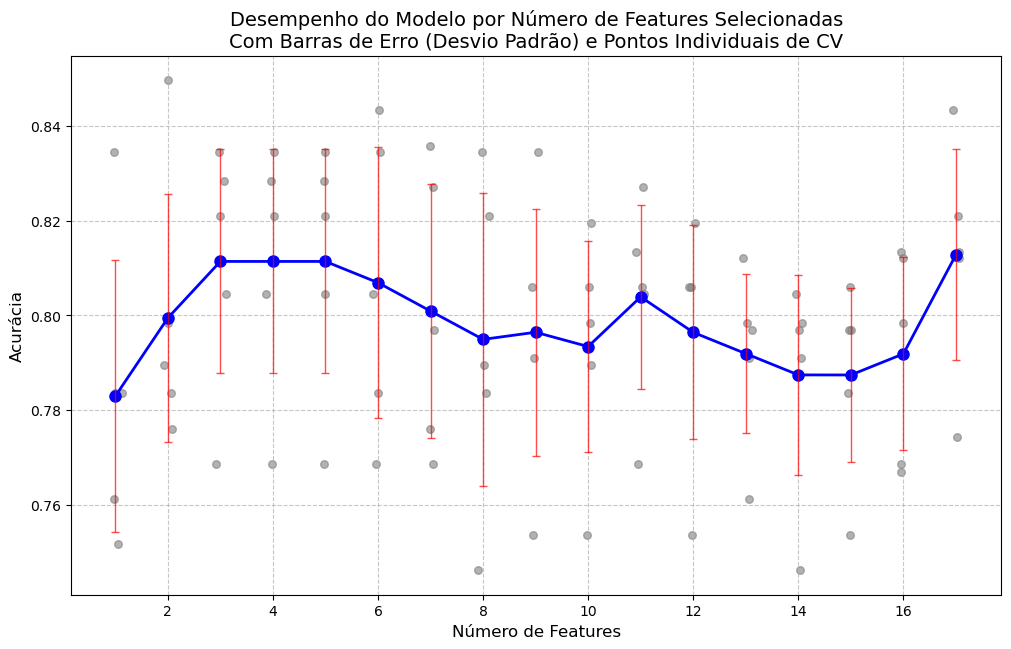

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(
    num_features, 
    avg_scores, 
    marker='o', 
    linestyle='-', 
    color='b', 
    linewidth=2,
    markersize=8)

# Adicionar barras de erro (desvio padrão)
plt.errorbar(
    num_features, 
    avg_scores, 
    yerr=std_scores, 
    fmt='none', 
    ecolor='red', 
    elinewidth=1, 
    capsize=3, 
    alpha=0.7)

# Adicionar pontos individuais de cada fold da validação cruzada
for i, n in enumerate(num_features):
    # Espalhar os pontos horizontalmente para melhor visualização
    x_positions = np.random.normal(n, 0.05, size=len(cv_scores[i]))
    plt.scatter(x_positions, cv_scores[i], color='gray', alpha=0.6, s=30)

plt.xlabel('Número de Features', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.title('Desempenho do Modelo por Número de Features Selecionadas\nCom Barras de Erro (Desvio Padrão) e Pontos Individuais de CV', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)